In [1]:
#########################
# 5-10 December 2021    #
# Tonale Winter School  #
#########################

In [2]:
#Python Notebook written by Marta Spinelli
#Acknowledgements: Siyambonga Mashawule, Sibonelo Ngobese, Melis Irfan

1$^{st}$ PART

In [3]:
import numpy as np
import healpy as hp
from astropy.io import fits
import scipy.ndimage as ndimage
from sklearn.decomposition import FastICA
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### We want to construct a mock 21cm IM data cube.
We will need various ingredients:
1. The foregrounds 
2. The 21cm signal 

# 1. The foregrounds

## Diffuse Synchrotron emission

Read in Haslam map at 408 MHz (the improved desptriped and desourced version of Remazeilles2014)

In [9]:
file_sync='input/haslam408_dsds_Remazeilles2014.fits'
hdul = fits.open(file_sync)
data = hdul[1]
map_sync=hp.read_map(data, dtype=None)
nside=512
print('map len: ', len(map_sync))
print('for nisde 512 should be: ', hp.nside2npix(nside))

map len:  3145728
for nisde 512 should be:  3145728


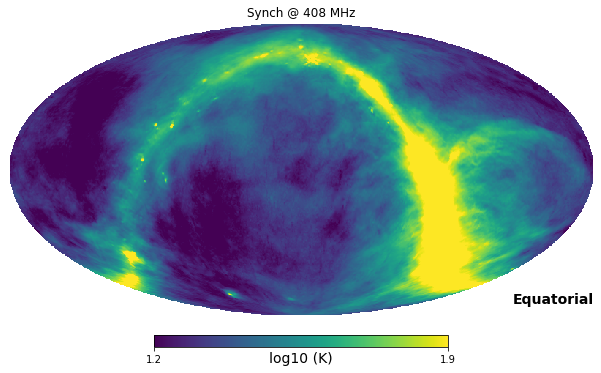

In [10]:
hp.mollview(np.log10(map_sync), coord=['G','C'], min=1.2,max=1.9, title='Synch @ 408 MHz', unit='log10 (K)')

Text(0, 0.5, '$C_\\ell \\;({\\rm K}^2)$')

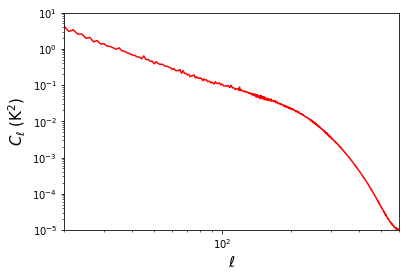

In [11]:
cl=hp.anafast(map_sync)
ell=np.arange(len(cl))

plt.plot(ell,cl,linestyle='-', color='r')

plt.yscale('log')
plt.xscale('log')
plt.xlim(20,600)
plt.ylim(1e-5,1e1)
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell \;({\rm K}^2)$", fontsize=15)

Need to scale this in our frequancy range of interest. We need a spectral index map

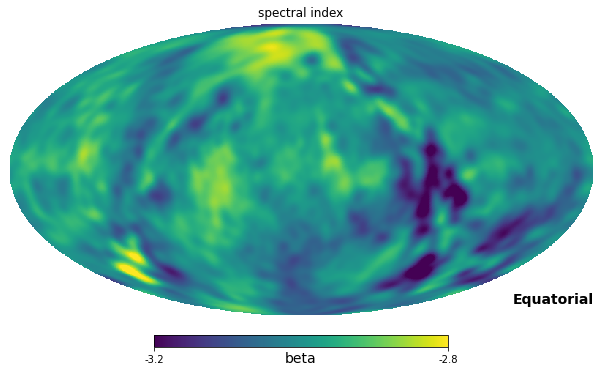

In [13]:
#This beta map is just obtained between 2 freq of the Planck Sky Model
beta=hp.read_map('input/beta_synch_map.fits',dtype=None)
hp.mollview(beta, coord=['G','C'], min=-3.2,max=-2.8, title='spectral index', unit='beta')

## Free-Free

Free free map from Planck Sky Model 

In [17]:
map_ff=hp.read_map('input/freefree217MHz_nside256_ffp10.fits',dtype=None)

In [18]:
nside=hp.npix2nside(len(map_ff))
print('nside=',nside)

nside= 256


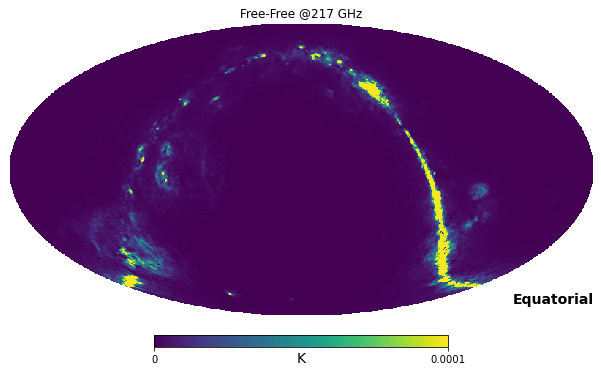

In [19]:
hp.mollview(map_ff, min=0,max=1e-4, unit='K', title='Free-Free @217 GHz',coord=['G','C'])

Text(0, 0.5, '$C_\\ell \\;({\\rm K}^2)$')

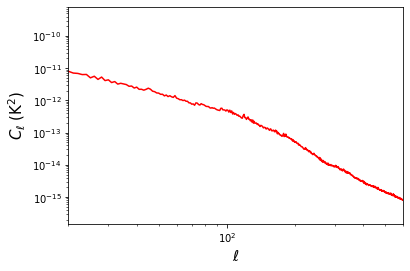

In [20]:
cl=hp.anafast(map_ff)
ell=np.arange(len(cl))

plt.plot(ell,cl,linestyle='-', color='r')

plt.yscale('log')
plt.xscale('log')
plt.xlim(20,600)
#plt.ylim(1e-5,1e1)
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell \;({\rm K}^2)$", fontsize=15)

In [21]:
print(len(cl),3*nside)

768 768


We can assume $\beta_{ff}=-2.1$ 

## Point Sources

Point source map from Matshawule et al (2021) #NB units are mK

In [28]:
map_ps=hp.read_map('input/PSmap_1300MHz.fits',dtype=None)
nside=hp.npix2nside(len(map_ps))
print('nside=',nside)

nside= 512


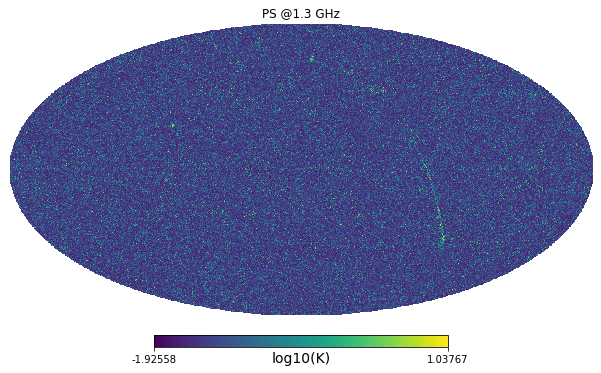

In [29]:
hp.mollview(np.log10(map_ps), unit='log10(K)', title='PS @1.3 GHz')

Text(0, 0.5, '$C_\\ell \\;({\\rm K}^2)$')

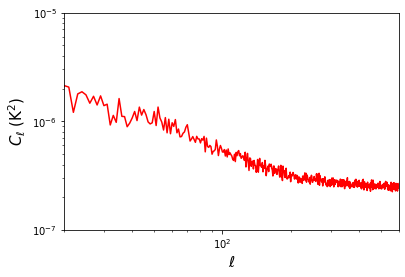

In [30]:
cl=hp.anafast(map_ps)
ell=np.arange(len(cl))

plt.plot(ell,cl,linestyle='-', color='r')

plt.yscale('log')
plt.xscale('log')
plt.xlim(20,600)
plt.ylim(1e-7,1e-5)
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell \;({\rm K}^2)$", fontsize=15)

We make now the wring assumption of scaling pixels instead of sigle sources with a given spectral index. 
We assume $\mathcal{N}(-0.8,0.2)$

# Let's now focus on a smaller patch!

In [31]:
def footprint(ra_c,dec_c):
    #some realistic hardcoded values
    Ny=51
    Nx=151
    Delta=0.5
    ra = np.linspace(ra_c-((Nx-1)/2)*Delta,ra_c+((Nx-1)/2)*Delta,Nx)
    dec = np.linspace(dec_c-((Ny-1)/2)*Delta,dec_c+((Ny-1)/2)*Delta,Ny)
    ra_edges=np.zeros(Nx+1)
    dec_edges=np.zeros(Ny+1)
    ra_edges[1:]=ra+Delta
    ra_edges[0]=ra[0]-Delta
    dec_edges[1:]=dec+Delta
    dec_edges[0]=dec[0]-Delta
    return ra,dec,ra_edges,dec_edges

In [32]:
def cut_patch_flat(nside,map_in,ra_M,dec_M):
    #note it need pixel EDGES
    map_ud=hp.ud_grade(map_in,nside)

    npix=hp.nside2npix(nside)
    ipix=np.arange(npix)
    theta, phi=hp.pix2ang(nside,ipix)
    ra=phi
    dec=theta-np.pi/2.

    patch=np.zeros((len(ra_M)-1,len(dec_M)-1))
    for ir in range(len(ra_M)-1):
        for idd in range(len(dec_M)-1):
            pM=np.where((ra>ra_M[ir]/180*np.pi) & (ra<ra_M[ir+1]/180*np.pi) & (dec<dec_M[idd+1]/180*np.pi) & (dec>dec_M[idd]/180*np.pi))
            patch[ir,-idd-1]=np.mean(map_ud[pM])
            
    return patch

In [33]:
def rot_map(nside,i_coord,f_coord,Map):
    #examples: 'C' for celestial, 'G' for galactic
    npix=hp.nside2npix(nside)
    Map_new=np.zeros(npix)
    ipix=np.arange(npix)
    theta, phi=hp.pix2ang(nside,ipix)
    r = hp.Rotator(coord=[f_coord,i_coord]) 
    theta_new, phi_new=r(theta,phi)
    ipix_new=hp.ang2pix(nside,theta_new,phi_new)

    Map_new=Map[ipix_new]
    return Map_new

In [34]:
def plot_patch(patch,label,title):

    fig, ax = plt.subplots()
    norm=plt.Normalize(vmin=np.min(patch), vmax=np.max(patch))
    extent=[np.min(ra),np.max(ra),np.min(dec),np.max(dec)]
    ax = plt.gca()
    im = ax.imshow(patch.T,extent=extent,norm=norm,origin='lower')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax,label=label)


    ax.set_xlabel(r'${\rm R.A} (J2000) [^\circ]$',fontsize=15)
    ax.set_ylabel(r'${\rm Dec} (J2000) [^\circ]$',fontsize=15)
    fig.tight_layout()

In [47]:
#choose central ra and dec similar to MeerKLASS
ra,dec,ra_edges,dec_edges= footprint(160,-10)

In [48]:
np.savez('output/MK_footprint.npz',ra=ra,dec=dec,ra_edges=ra_edges,dec_edges=dec_edges)

In [49]:
#remember to rotate to Celestial coordinate (what is not already)!
cmap_sync=rot_map(512,'G','C',map_sync)
cbeta_synch=rot_map(512,'G','C',beta)
cmap_ps=map_ps #no need to rotate
cmap_ff=rot_map(256,'G','C',map_ff) #need to rotate at the same nside

maybe check all rotated correctly!

Time to cut down to the choosen patch

In [50]:
patch_synch = cut_patch_flat(256,cmap_sync,ra_edges,dec_edges) #remeber Synch is at 408 MHz
patch_ps = cut_patch_flat(256,cmap_ps,ra_edges,dec_edges) #remeber PS are defined at 1.3 GHz
patch_ff = cut_patch_flat(256,cmap_ff,ra_edges,dec_edges) #remeber free-free is defined at 217 GHz

In [51]:
patch_betasy = cut_patch_flat(256,cbeta_synch,ra_edges,dec_edges) #spectral index for synch

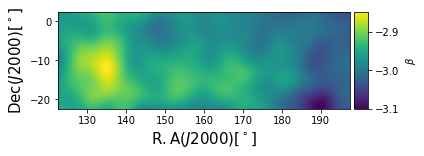

In [52]:
title=''
label=r'$\beta$'
plot_patch(patch_betasy,label,title)

# Define frequency range and create the foreground data-cubes

In [53]:
def f2z(f):
    #input freq in MHz
    #1+z =fe/fo
    return 1420./f-1

In [54]:
fmin=850.
fmax=949.
Df=1. 
zmin=f2z(fmax)
zmax=f2z(fmin)
print(zmin, zmax)

0.4963119072708113 0.6705882352941177


In [55]:
freqs=np.arange(fmin,fmax+Df,Df)

In [56]:
#what shape must have our data cube? (Nx,Ny,Nf)
Nx=patch_synch.shape[0]
Ny=patch_synch.shape[1]
Nf=len(freqs)
print(Nx,Ny,Nf)

151 51 100


### Syncrotron data-cube

In [57]:
cube_synch=np.zeros((Nx,Ny,Nf))
for ii,ff in enumerate(freqs):
    cube_synch[:,:,ii]=patch_synch*((ff/408.)**patch_betasy)
    
np.savez('output/cube_patch_synch.npz',cube_patch=cube_synch)

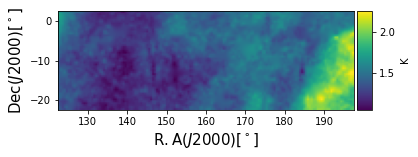

In [58]:
title=''
label=r'${\rm K}$'
plot_patch(cube_synch[:,:,99],label,title)

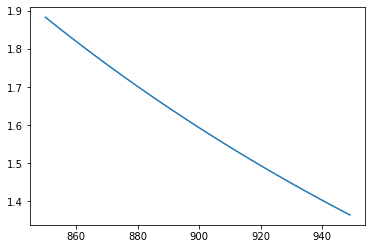

In [59]:
#double check it scales right
plt.plot(freqs,cube_synch[10,10,:])

### Free-Free data-cube

In [60]:
cube_ff=np.zeros((Nx,Ny,Nf))
for ii,ff in enumerate(freqs):
    cube_ff[:,:,ii]=patch_ff*((ff/(217*1e3))**-2.1)
    
np.savez('output/cube_patch_ff.npz',cube_patch=cube_ff)

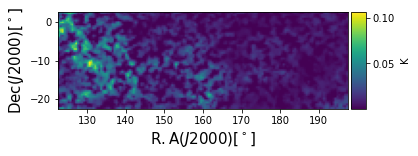

In [61]:
title=''
label=r'${\rm K}$'
plot_patch(cube_ff[:,:,99],label,title)

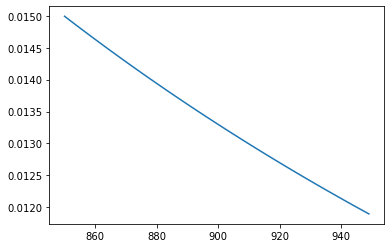

In [62]:
#double check it scales right
plt.plot(freqs,cube_ff[10,10,:])

### Point sources data-cube

Create spectral index map $\mathcal{N}(-0.8,0.2)$ 

We are making a rough approx: all source in the same pixel scales with the same beta

(array([   8.,   39.,  242.,  789., 1727., 2117., 1661.,  838.,  245.,
          35.]),
 array([-1.57617968, -1.43415035, -1.29212101, -1.15009167, -1.00806234,
        -0.866033  , -0.72400366, -0.58197432, -0.43994499, -0.29791565,
        -0.15588631]),
 <a list of 10 Patch objects>)

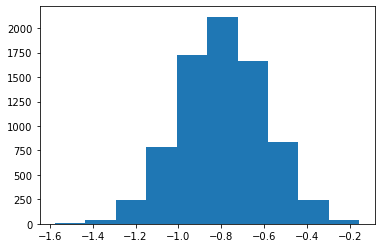

In [63]:
seed=1234
np.random.seed(seed)
beta_ps=np.random.normal(-0.8,0.2, Nx*Ny).reshape((Nx,Ny))
plt.hist(beta_ps.flatten())

In [64]:
cube_ps=np.zeros((Nx,Ny,Nf))
for ii,ff in enumerate(freqs):
    cube_ps[:,:,ii]=patch_ps*((ff/408.)**beta_ps)
    
np.savez('output/cube_patch_ps.npz',cube_patch=cube_ps)

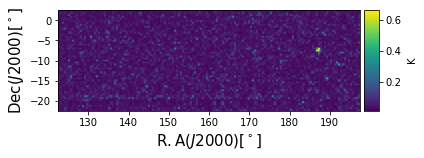

In [65]:
title=''
label=r'${\rm K}$'
plot_patch(cube_ps[:,:,10],label,title)

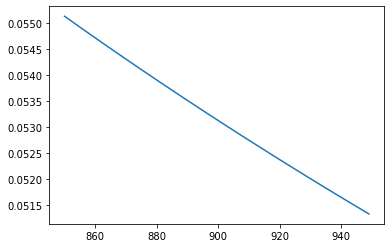

In [66]:
#double check it scales right
plt.plot(freqs,cube_ps[10,10,:])

# 21cm mock maps

### We will use CRIME simulations (Alonso et al. 2014) http://intensitymapping.physics.ox.ac.uk/CRIME.html

#### The code creates full sky maps. Here we load in directly a patch version

In [68]:
cube_HI=np.load('input/HI_cube.npz')['cube_HI'] #the units in mK!!

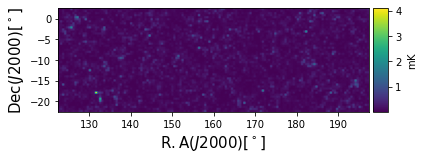

In [69]:
title=''
label=r'${\rm mK}$'
plot_patch(cube_HI[:,:,20],label,title)

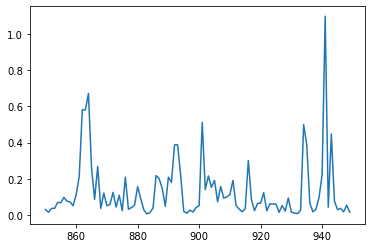

In [70]:
#how does it scale?
plt.plot(freqs,cube_HI[1,10,:])